# Modeling

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.combine import SMOTEENN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras import regularizers

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# Load data
train = pd.read_csv('assets/working/feat_train.csv')
test = pd.read_csv('assets/working/feat_test.csv')
spray = pd.read_csv('assets/working/feat_spray.csv')

In [7]:
# Define function to ensure equal columns in the train and test datasets (taken from EDA notebook)
def leveller(train, test):
    tr_features = set(train.columns)
    te_features = set(test.columns)
    for missing_col in tr_features - te_features:
        test[missing_col] = 0
    return train, test[train.columns]

#### Balance Classes

Since our target variable only makes up for 5% of the data, we will need to artificially balance the classes so that our models perform better. We want to use a combination of under and over sampling, so we will use the SMOTE method to accomplish this.  

In [8]:
# Define X and y
X = train.drop(['WnvPresent', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'SeaLevel','Day','Station', 'Tmax', 'Tmin',
               'Latitude','Longitude', 'Trap'], axis = 1)
y = train['WnvPresent']

In [9]:
# Convert Year and Month to Dummies
X = pd.get_dummies(X, columns = ['Month'])

In [10]:
# Kaggle Submission preprocessing to match 
X_test_kaggle = pd.get_dummies(test, columns = ['Month'])
X_test_kaggle.drop('WnvPresent', axis = 1, inplace = True)
_, X_test_kaggle = leveller(X, X_test_kaggle)

In [11]:
# Use SMOTE method to balance classes
sme = SMOTEENN()
X_res, y_res = sme.fit_sample(X, y)

In [12]:
# Check class balance 
pd.Series(y_res).value_counts(normalize = True)

0    0.56376
1    0.43624
dtype: float64

With the balanced data, the baseline accuracy score to beat is 50%

#### Logistic Regression

In [13]:
# Train test split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [14]:
# Kaggle Submission preprocessing 
X_test_kaggle_sc = ss.transform(X_test_kaggle)

In [15]:
# Fit model and accuracy score
logreg = LogisticRegression()
model_logreg = logreg.fit(X_train, y_train)
model_logreg.score(X_train, y_train), model_logreg.score(X_test, y_test)

(0.8509171148807061, 0.8651778329197684)

In [16]:
# Evaluate model with AUC-ROC score
y_score = model_logreg.predict(X_test)
metrics.roc_auc_score(y_test, y_score)

0.8666385426653883

In [20]:
# Gridsearch on logistic regression model above
lr_params = {'penalty':['l1', 'l2'], 
             'C': np.logspace(-5, 2, 10)}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.8579506274996552, {'C': 0.0774263682681127, 'penalty': 'l1'})

In [21]:
# Gridsearch test accuracy score
gs.score(X_test, y_test)

0.8784119106699751

In [22]:
# Evaluate gridsearched model with AUC-ROC score
y_score = gs.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score)

0.9121345768325634

Gridsearching improved the AUC-ROC score. Neither model was overfit. 

In [23]:
# Determine top predictors in model 
coefs = pd.DataFrame(gs.best_estimator_.coef_[0], index = X.columns, columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
Sunrise,4.870577
Year,2.859280
Month_8,2.818467
Tavg,2.151747
PrecipTotal,1.407150


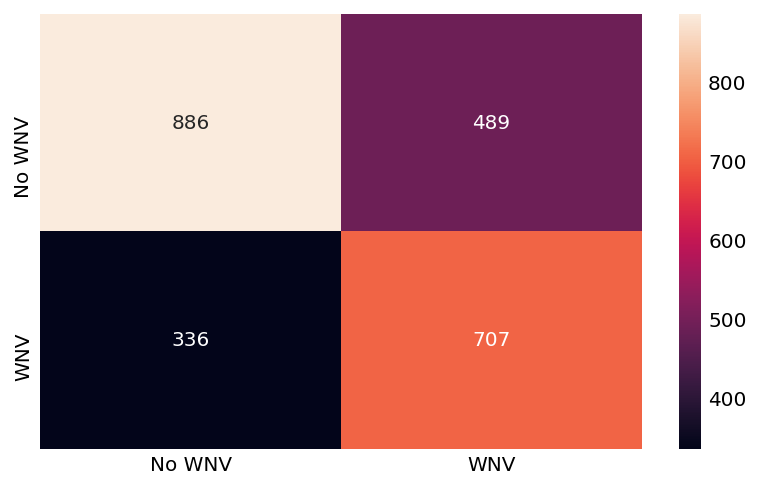

In [24]:
# Create a heatmap confusion matrix - get predictions 
predictions = gs.predict(X_test)

# Create confusion matrix 
classes = ["No WNV", 'WNV']
cm = metrics.confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g');

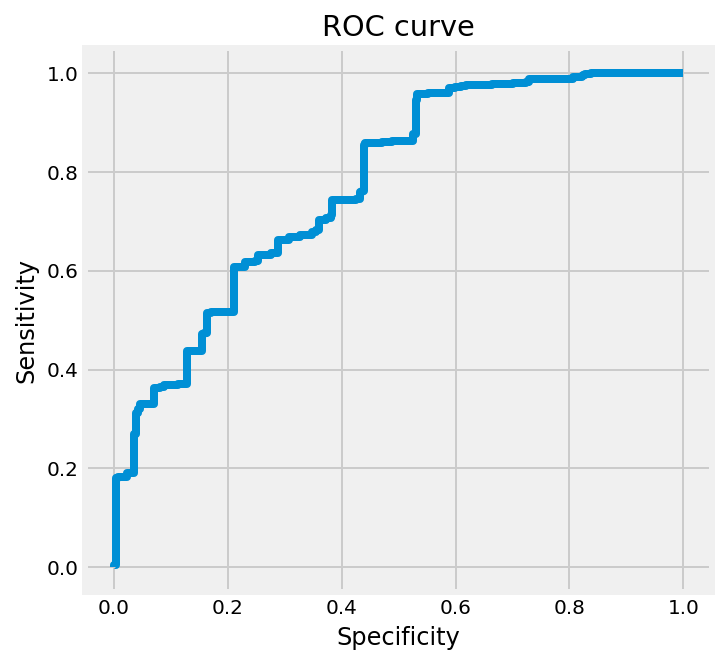

In [25]:
# ROC Plot 
y_probs = gs.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');

In [18]:
# Kaggle predictions dataframe and csv file
submission = pd.DataFrame()
submission['WnvPresent'] = gs.predict(X_test_kaggle_sc)
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('kaggle/submission_logreg.csv', index = False)

On Kaggle this model achieved a AUC-ROC score of 0.63253

With 'Year' as a numeric feature and with all species features removed, this model achieved an AuC-RoC Kaggle score of 0.67215

#### CNN

In [21]:
# Train test split and standardize data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [22]:
# Kaggle Submission preprocessing 
X_test_kaggle_sc = ss.transform(X_test_kaggle)

In [23]:
# Reshape our NumPy array 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test_kaggle_shaped = X_test_kaggle_sc.reshape(X_test_kaggle_sc.shape[0], X_test_kaggle_sc.shape[1], 1)

# Convert dtype from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_test_kaggle_shaped = X_test_kaggle_shaped.astype('float32')

In [24]:
# Preprocess Y data
y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y_test, 2 )

In [25]:
# Define Model Architecture
model = Sequential()
model.add(Convolution1D(filters=10, kernel_size=3, activation="relu", input_shape = (X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Convolution1D(filters=20, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Convolution1D(filters=30, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size = 2)) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(X_train.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

# Compile
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [26]:
# Fit model with training data
model.fit(X_train, y_train, batch_size = 32, epochs = 30, verbose = 1)

Epoch 1/30
8418/8418 [==============================] - 3s 357us/step - loss: 1.2447 - acc: 0.7315
Epoch 2/30
8418/8418 [==============================] - 2s 240us/step - loss: 0.4862 - acc: 0.8888
Epoch 3/30
8418/8418 [==============================] - 2s 237us/step - loss: 0.3568 - acc: 0.9236
Epoch 4/30
8418/8418 [==============================] - 2s 285us/step - loss: 0.2893 - acc: 0.9398
Epoch 5/30
8418/8418 [==============================] - 2s 255us/step - loss: 0.2597 - acc: 0.9481
Epoch 6/30
8418/8418 [==============================] - 2s 243us/step - loss: 0.2376 - acc: 0.9513
Epoch 7/30
8418/8418 [==============================] - 2s 254us/step - loss: 0.2292 - acc: 0.9545
Epoch 8/30
8418/8418 [==============================] - 2s 287us/step - loss: 0.2173 - acc: 0.9577
Epoch 9/30
8418/8418 [==============================] - 2s 271us/step - loss: 0.1988 - acc: 0.9587
Epoch 10/30
8418/8418 [==============================] - 2s 279us/step - loss: 0.2028 - acc: 0.9593
Epoch 11/

In [27]:
# CNN model summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 161, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 80, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 78, 20)            620       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 30)            1830      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 30)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 30)            0         
__________

In [28]:
# Score model on test data
score = model.evaluate(X_test, Y_test, verbose = 1)
labels = model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

2806/2806 [==============================] - 0s 130us/step
loss: 0.11286547898460267
acc: 0.9818246613123208


In [29]:
# Evaluate model with AUC-ROC score
y_score = model.predict(X_test)
metrics.roc_auc_score(Y_test, y_score)

0.9946479237232217

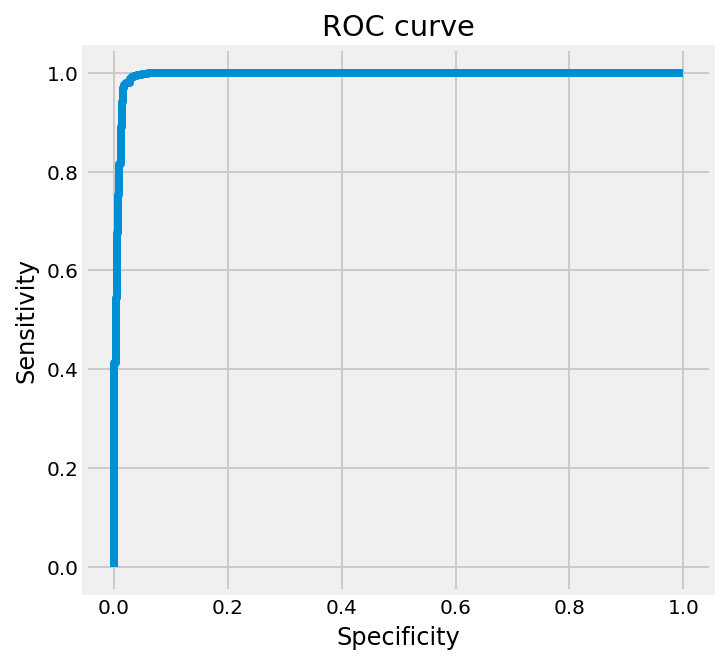

In [30]:
# AUC - ROC Plot 
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');

In [31]:
# Kaggle predictions dataframe and csv file
submission = pd.DataFrame()
submission['WnvPresent'] = model.predict_proba(X_test_kaggle_shaped)[:,1]
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('kaggle/submission_cnn.csv', index = False)

On Kaggle this model achieved a AUC-ROC score of 0.58692

#### Decision Tree Classifier

In [11]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [12]:
# Gridsearch for optimal parameters
params = {
    'max_depth': [None, 2,3],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf':[1,2,3],
    'max_features':[None, 'sqrt', 'log2']
}

gs_dtc = GridSearchCV(DecisionTreeClassifier(),params)
gs_dtc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 2, 3], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
# Check out scores
print(gs_dtc.best_score_, gs_dtc.score(X_test, y_test), gs_dtc.best_params_)

0.9714142928535732 0.9778110944527736 {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [14]:
# RoC score
y_hat = gs_dtc.predict(X_test)

metrics.roc_auc_score(y_test, y_hat)

0.9778839192283832

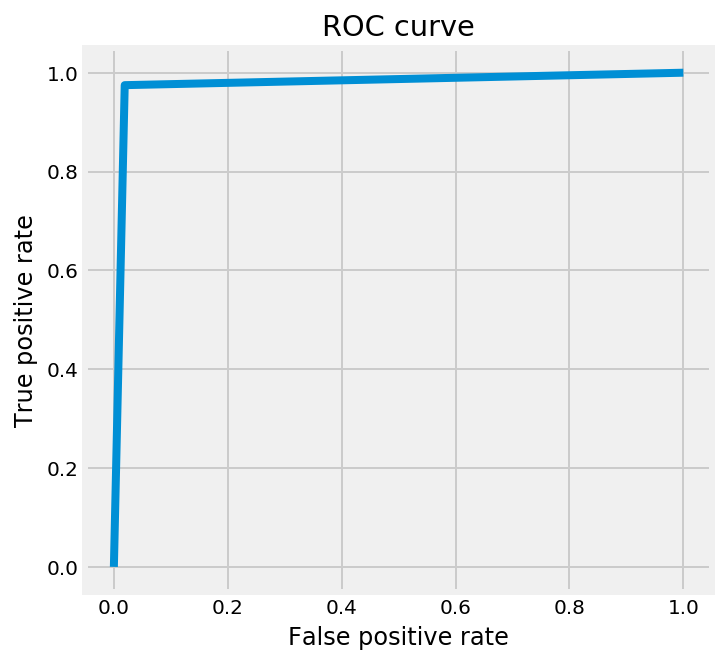

In [15]:
# RoC Plot
y_probs = gs_dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

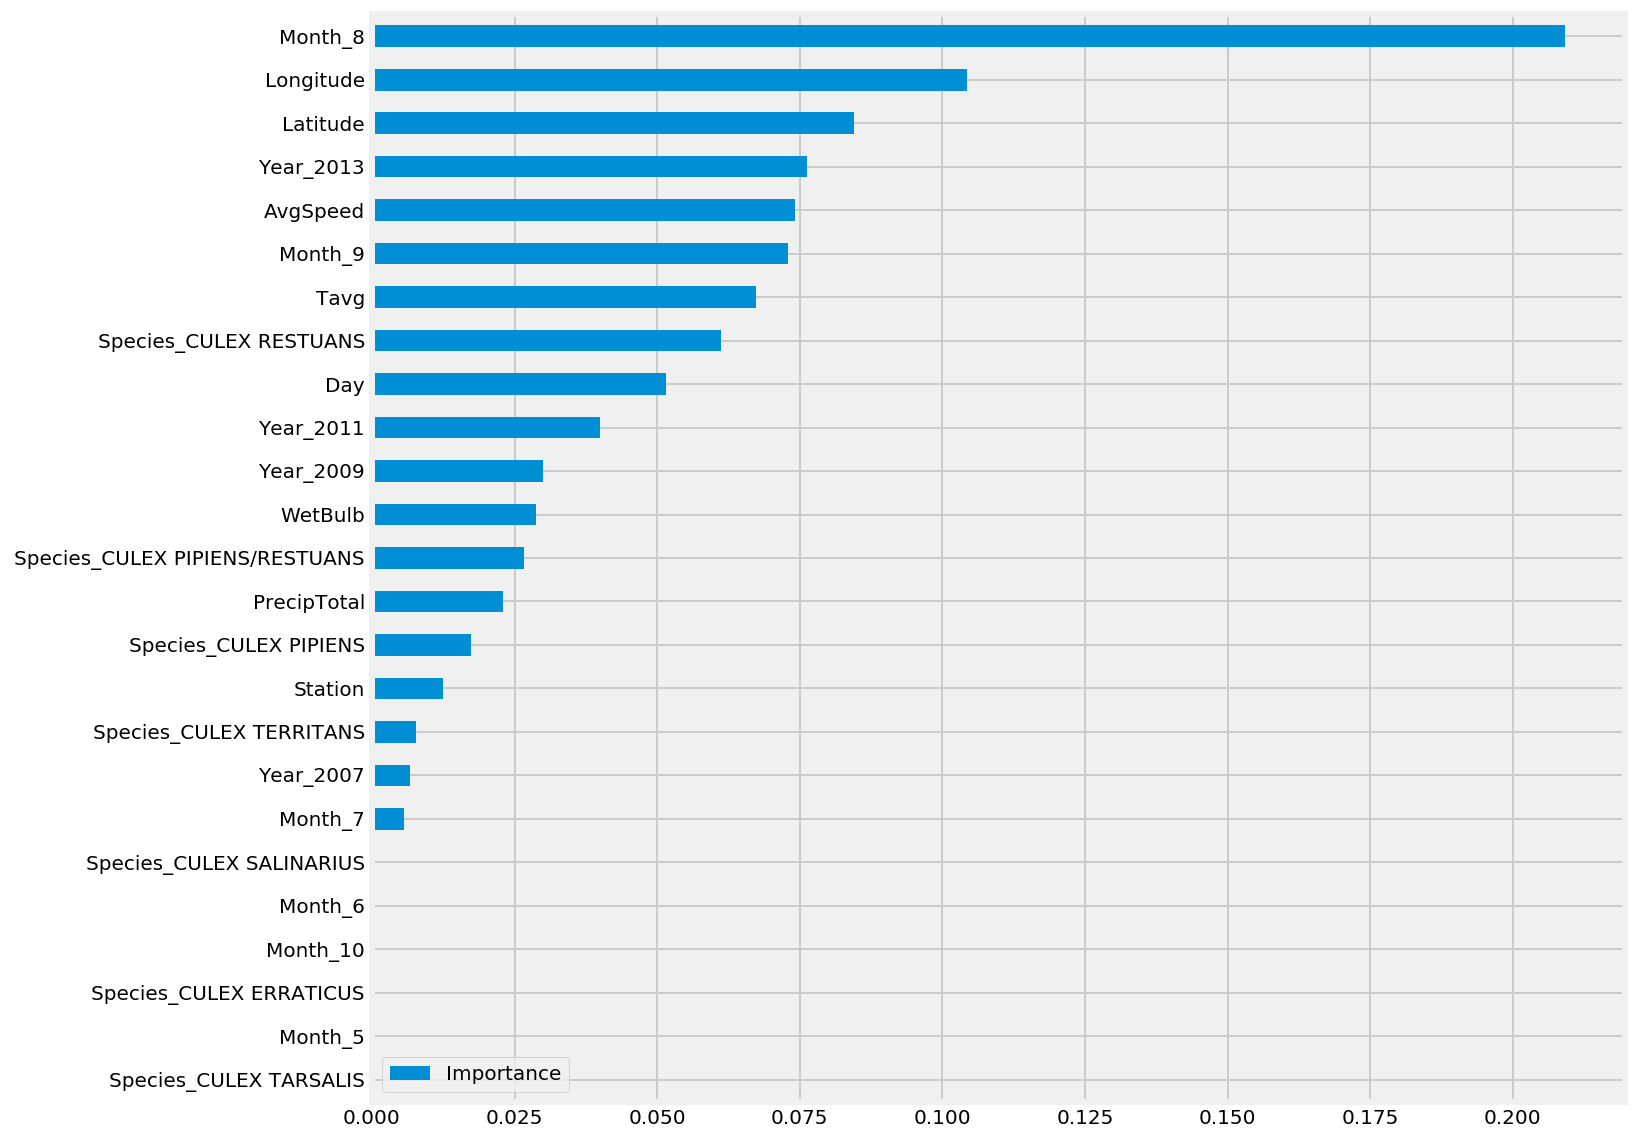

In [16]:
# Important coefs
coefs = pd.DataFrame(gs_dtc.best_estimator_.feature_importances_, index = X.columns, columns = ['Importance'])

axes = coefs.sort_values(by='Importance').plot(kind='barh',figsize = (10,10))

In [21]:
# Make kaggle submission
y_hat = gs_dtc.predict_proba(X_test_kaggle)
submission = pd.DataFrame(y_hat, columns = ['WnvPresent'])
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('kaggle/submission-dtc.csv', index=False)

This model scored 0.50794 on Kaggle.

#### Support Vector Classifier

In [23]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [24]:
# Standardize our data for support vector analysis
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
X_test_kaggle_sc = ss.transform(X_test_kaggle)

In [25]:
# fit an untuned model
sv = SVC(probability=True, C=1.0)
sv.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Check accuracy on training data
sv.score(X_train, y_train)

0.8926536731634183

In [27]:
# Check accuracy on test data
sv.score(X_test, y_test)

0.8920539730134932

Looks like we didn't overfit.

In [28]:
# Make predictions and check RoC score
y_hat = sv.predict(X_test)

metrics.roc_auc_score(y_test, y_hat)

0.8914912295857323

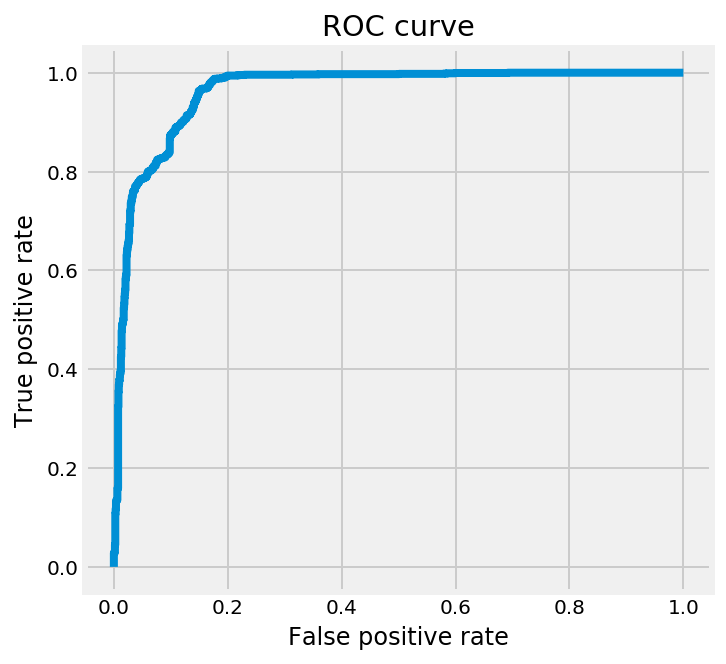

In [29]:
# RoC Plot
y_probs = sv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [30]:
# GridSearch for optimal kernel and C value

params = {
    'C' : [.5, 1.0, 1.5],
    'kernel' : ['rbf', 'linear','sigmoid' ]
}
gs_sv = GridSearchCV(SVC(probability=True), params)
gs_sv.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1.0, 1.5], 'kernel': ['rbf', 'linear', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
# Look at scores
print(gs_sv.best_score_, gs_sv.score(X_test_sc, y_test), gs_sv.best_params_)

0.9366316841579211 0.9481259370314843 {'C': 1.5, 'kernel': 'rbf'}


In [32]:
# Check out RoC score
y_hat = gs_sv.predict(X_test_sc)
metrics.roc_auc_score(y_test,y_hat)

0.947409909423498

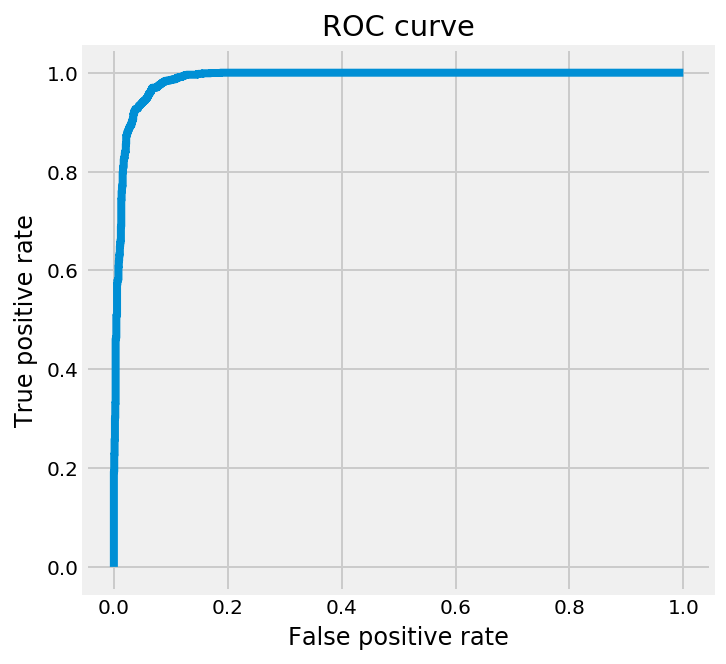

In [33]:
# RoC Plot
y_probs = gs_sv.predict_proba(X_test_sc)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

The grid-searched SVC has a better RoC score.

In [23]:
# Kaggle submission
y_hat = gs_sv.predict_proba(X_test_kaggle_sc)
submission = pd.DataFrame(y_hat, columns = ['WnvPresent'])
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('kaggle/submission-svc.csv', index=False)

NameError: name 'gs_sv' is not defined

This model scored 0.50000 on Kaggle (yikes)

#### Adaboost (Decision Tree Classifier)

In [36]:
# Adaboost a decision tree classifier
ada_dtc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
ada_dtc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [37]:
# Check RoC score
y_hat = ada_dtc.predict(X_test)
print(metrics.roc_auc_score(y_test, y_hat))

0.9801233098793322


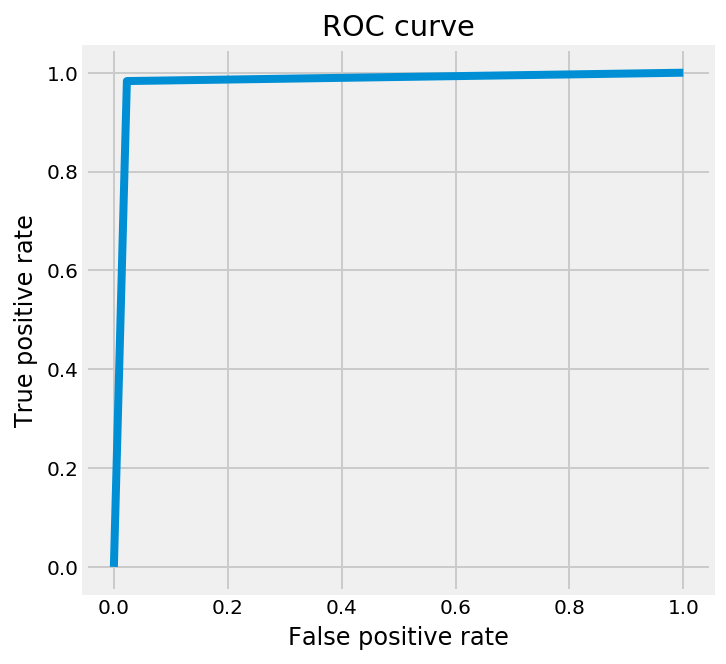

In [38]:
# Plot RoC curve
y_probs = ada_dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [39]:
# Kaggle submission
y_hat = ada_dtc.predict_proba(X_test_kaggle)
submission = pd.DataFrame(y_hat, columns = ['WnvPresent'])
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('kaggle/submission-ada-dtc.csv', index=False)

This model scored 0.52478 on Kaggle.

#### Random Forest Classifier

In [199]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [200]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9871180347513481

In [201]:
y_probs = rf.predict_proba(X_test)[:, 1]

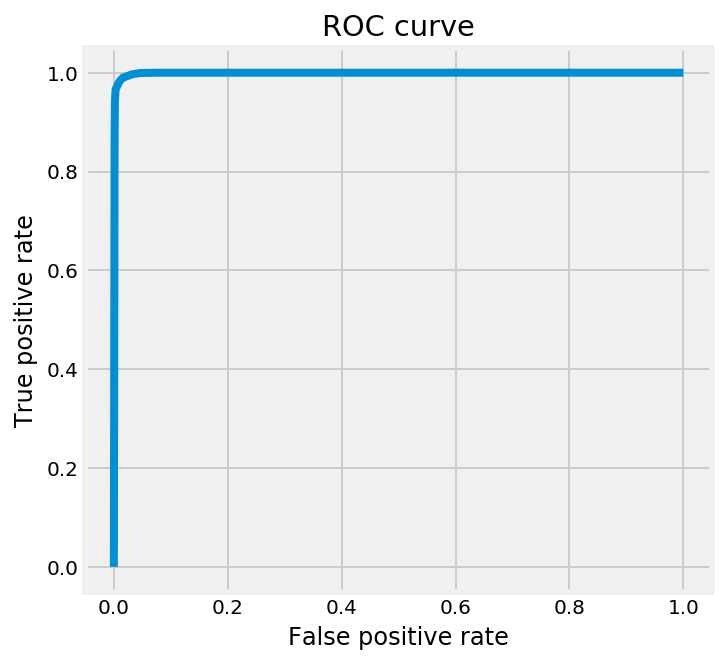

In [202]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

#### Extra Trees Classifier

In [203]:
et = ExtraTreesClassifier()
et.fit(X_train,y_train)
et.score(X_test,y_test)

0.9943079688436189

In [204]:
y_probs = et.predict_proba(X_test)[:, 1]

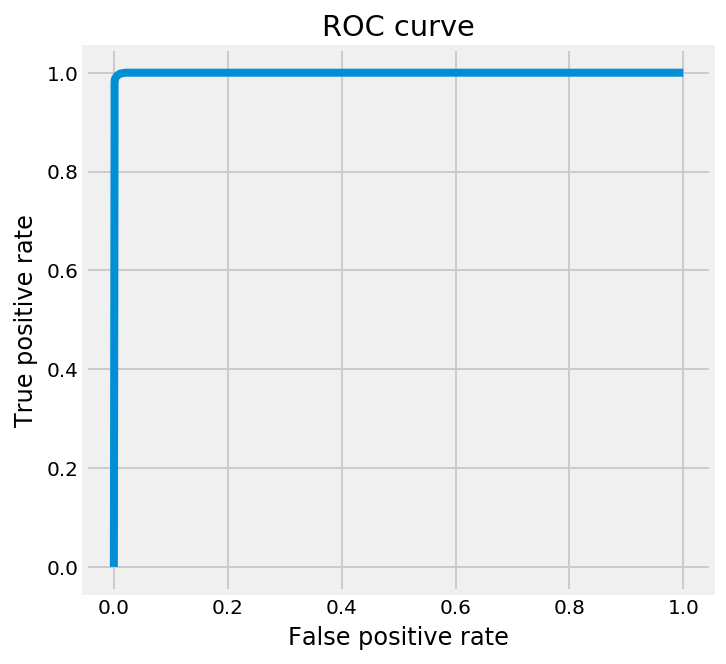

In [205]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

#### Deep Neural Network

In [206]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res , stratify = y_res) ## We want to stratify for classification

ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)
X_test_kaggle_sc = ss.transform(X_test_kaggle)

In [208]:
model = Sequential()
model.add(Dense(25, activation = 'relu', input_dim = X_res.shape[1],kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(25, activation = 'relu', input_dim = 25))
model.add(Dropout(0.15))
model.add(Dense(10, activation = 'relu', input_dim = 25))
model.add(Dense(1, activation = 'sigmoid')) ## Output layer

In [209]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [210]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, verbose = 1)

Train on 10011 samples, validate on 3338 samples
Epoch 1/50
10011/10011 [==============================] - 2s 182us/step - loss: 1.4966 - acc: 0.5288 - val_loss: 0.7246 - val_acc: 0.6345
Epoch 2/50
10011/10011 [==============================] - 1s 83us/step - loss: 0.7441 - acc: 0.5566 - val_loss: 0.7079 - val_acc: 0.5294
Epoch 3/50
10011/10011 [==============================] - 1s 74us/step - loss: 0.7157 - acc: 0.5641 - val_loss: 0.7034 - val_acc: 0.5920
Epoch 4/50
10011/10011 [==============================] - 1s 71us/step - loss: 0.7007 - acc: 0.5906 - val_loss: 0.6656 - val_acc: 0.6375
Epoch 5/50
10011/10011 [==============================] - 1s 77us/step - loss: 0.6873 - acc: 0.6101 - val_loss: 0.6460 - val_acc: 0.7070
Epoch 6/50
10011/10011 [==============================] - 1s 65us/step - loss: 0.6690 - acc: 0.6351 - val_loss: 0.6459 - val_acc: 0.6705
Epoch 7/50
10011/10011 [==============================] - 1s 66us/step - loss: 0.6575 - acc: 0.6552 - val_loss: 0.5930 - val_acc

In [211]:
y_probs = model.predict(X_test)

In [212]:
metrics.roc_auc_score(y_test, y_probs)

0.9204778467025784

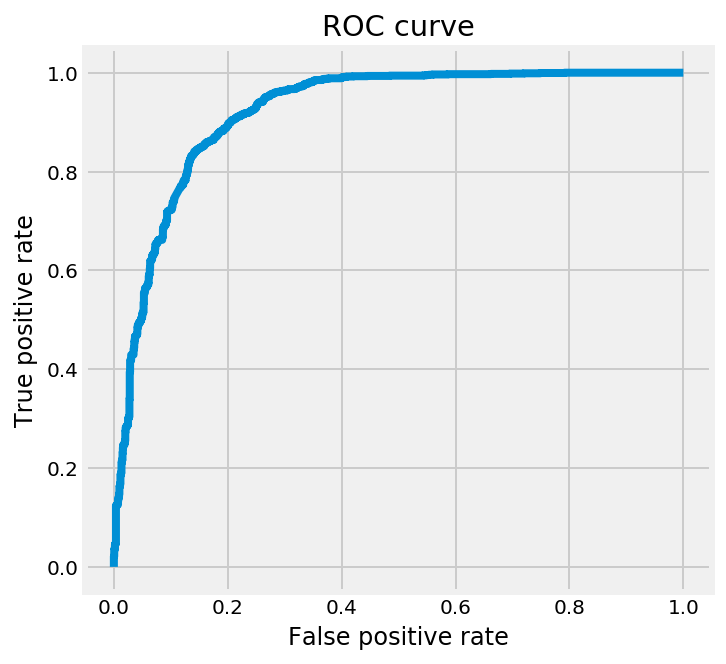

In [213]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

<function matplotlib.pyplot.legend>

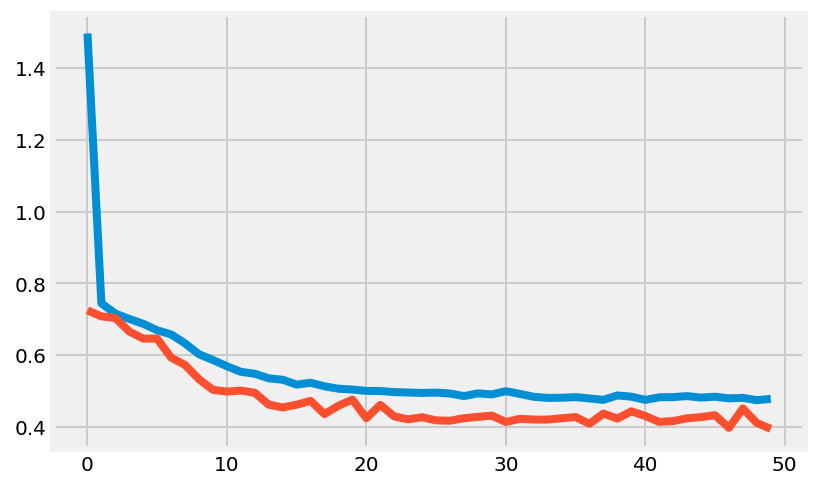

In [214]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.legend